In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Overview

- Test cases comparing 

# Hermes IO

In [2]:
casestore = dict()

In [3]:
db = CaseDB()

In [4]:
   

toload = [
    dict(name="A1_unch", id = "xafn-A-1_120test"),
    dict(name="B1_chained_noedgeflux", id = "xafn-B-1_120test"),
    dict(name="B2_separate_lims", id = "xafn-B-2_separate_lims"),
    dict(name="B3_seplims_limitcond", id = "xafn-B-3_seplims_limitcond"),
    dict(name="B4_seplims_limitcondvisc", id = "xafn-B-4_seplims_limitcondvisc"),
    dict(name="C1_chained_edgeflux", id = "xafn-C-1_120_nethfluxlim_mfp1"),
    dict(name="C2_chained_edgeflux_condlim", id = "xafn-C-2_condfluxlim"),
]
casestore = {}
for case in toload:
    casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True)

- Reading case xafn-A-1_120test
-----------------------
- Looking for squash file
- Squash file found. squash date 10/05/2023, 12:09:53, dmp file date 10/04/2023, 18:24:58

- Reading case xafn-B-1_120test
-----------------------
- Looking for squash file
- Squash file found. squash date 10/05/2023, 12:12:05, dmp file date 10/04/2023, 19:16:04

- Reading case xafn-B-2_separate_lims
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

- Reading case xafn-B-3_seplims_limitcond
-----------------------
- Looking for squash file
- Squash file found. squash date 10/06/2023, 10:19:52, dmp file date 10/05/2023, 19:43:48

- Reading case xafn-B-4_seplims_limitcondvisc
-----------------------
- Looking for squash file
- Squashoutput file not found, creating...
- Done

- Reading case xafn-C-1_120_nethfluxlim_mfp1
-----------------------
- Looking for squash file
- Squash file found. squash date 10/05/2023, 12:13:38, dmp file date 10/04/2023, 19:05:25


In [ ]:
db.casepaths

In [14]:
test = db.load_case_2D("xafn-B-2_separate_lims", use_squash = False, verbose = True)

- Reading case xafn-B-2_separate_lims
-----------------------



In [15]:
test.ds["t"].values[0]

0.6102256731129247

In [4]:
squash(db.casepaths["xafn-B-2_separate_lims"], force = True)

- Looking for squash file
- Squash file found. squash date 10/05/2023, 16:41:41, dmp file date 10/03/2023, 15:06:56
- Done


In [ ]:
squash()

In [4]:
plt.close("all")
%matplotlib inline

## Read Hermes data

In [6]:
hr = dict()
for hermes_case in casestore.keys(): 
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

chained
unchained


# Read SOLEDGE CSV data

In [21]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

## Read SOLPS

In [22]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

# Runtime

(0.6146573453904257, 0.614688)

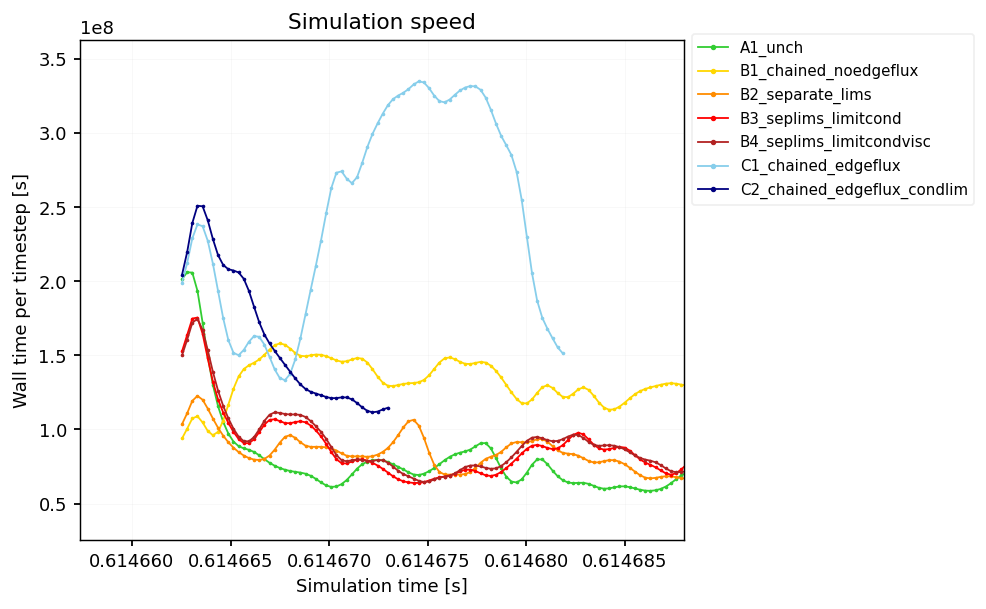

In [47]:
fig, ax = plt.subplots(dpi = 130)

colors = ["limegreen", "gold", "darkorange", "red", "firebrick", "skyblue", "navy"]

for i, case in enumerate(casestore):
    ds = casestore[case].ds
    wtime = ds["wtime"][:-1].values
    tstep = ds["t"].diff("t").values
    
    wtime_per_tstep = wtime/tstep
    time = ds["t"][:-1].values

    
    ax.plot(time, scipy.ndimage.gaussian_filter1d(wtime_per_tstep, 2), label = case, color = colors[i], lw = 1, marker = "o", ms = 1)
    
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlabel("Simulation time [s]")
ax.set_ylabel("Wall time per timestep [s]")
ax.set_title("Simulation speed")
ax.set_xlim(None,0.614688)

In [10]:
for i, case in enumerate(casestore):
    ds = casestore[case].ds
    print(case,ds["t"].values[0])

A1_unch 0.614662539133591
B1_chained_noedgeflux 0.614662539133591
B2_separate_lims 0.6102256731129247
B3_seplims_limitcond 0.614662539133591
B4_seplims_limitcondvisc 0.614662539133591
C1_chained_edgeflux 0.614662539133591
C2_chained_edgeflux_condlim 0.614662539133591


In [42]:
parse_solps("Ne", "outer_lower")

'ne3dr'

#  Neutral energy transport

In [17]:
for case in casestore:
    casestore[case].ds = calculate_radial_fluxes(casestore[case].ds)
    casestore[case].ds = reverse_pfr_fluxes(casestore[case].ds)

# Integrals

In [12]:
casestore.keys()

dict_keys(['chained', 'unchained'])

## OMP

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


Text(0.5, 1.0, '')

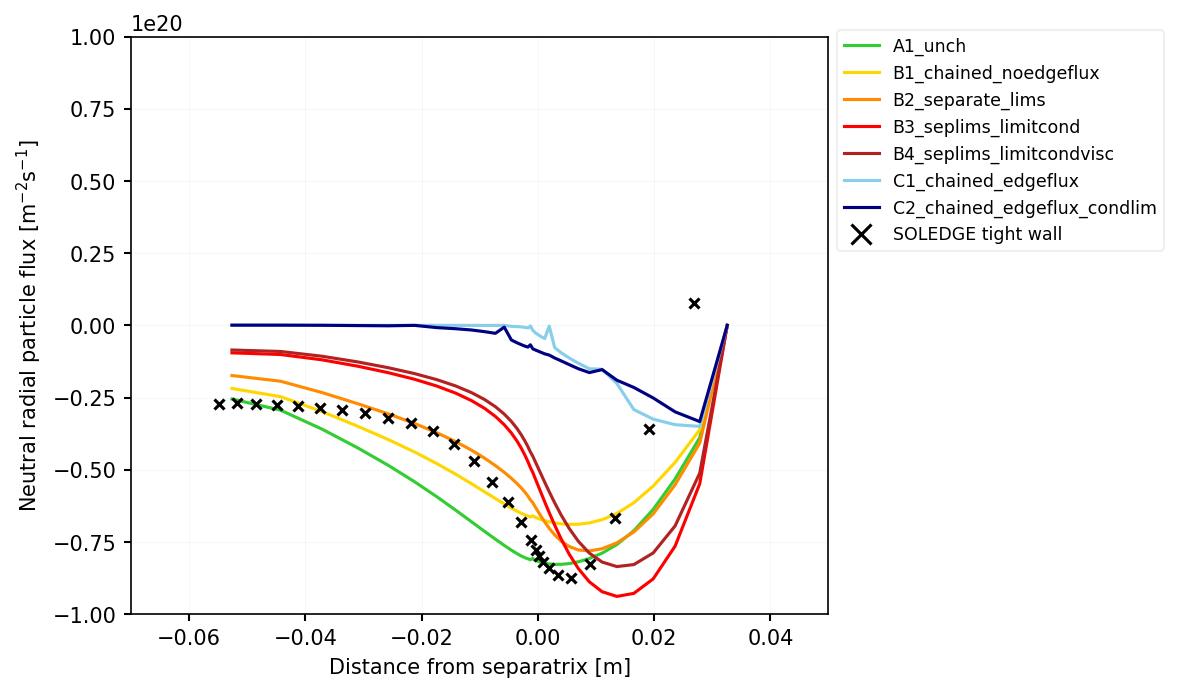

In [38]:
fig, ax = plt.subplots(dpi = 150)
labels = ['noafn', 'afn_unchained', 'afn_chained', 'afn_chained_mfp5', 'afn_chained_mfp10']

for i, case in enumerate(casestore):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = case, color = colors[i])

# ax2 = ax.twinx()
# ax2.plot(dist, omp["particle_flux_factor_d"])

# SOLPS
# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (lo res)", color = "black", lw=0, marker = "o", ms = 3)
# ax.plot(sp["16x_mc"].regions["omp"].index, sp["16x_mc"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (hi res)", color = "grey", lw=0, marker = "o", ms = 3)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE tight wall", c = "black")

# slc = SOLEDGEcase(path = soledgecases["widewall_2e19"])
# df = slc.get_1d_radial_data(["vxni", "Nni"])
# df["NVxn"] = df["vxni"] * df["Nni"]
# ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE wide wall", c = "darkorange")

ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("Distance from separatrix [m]")
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlim(-0.07, 0.05)
ax.set_ylim(-1.0e20, 1.0e20)
ax.set_title("")

Text(0.5, 1.0, '')

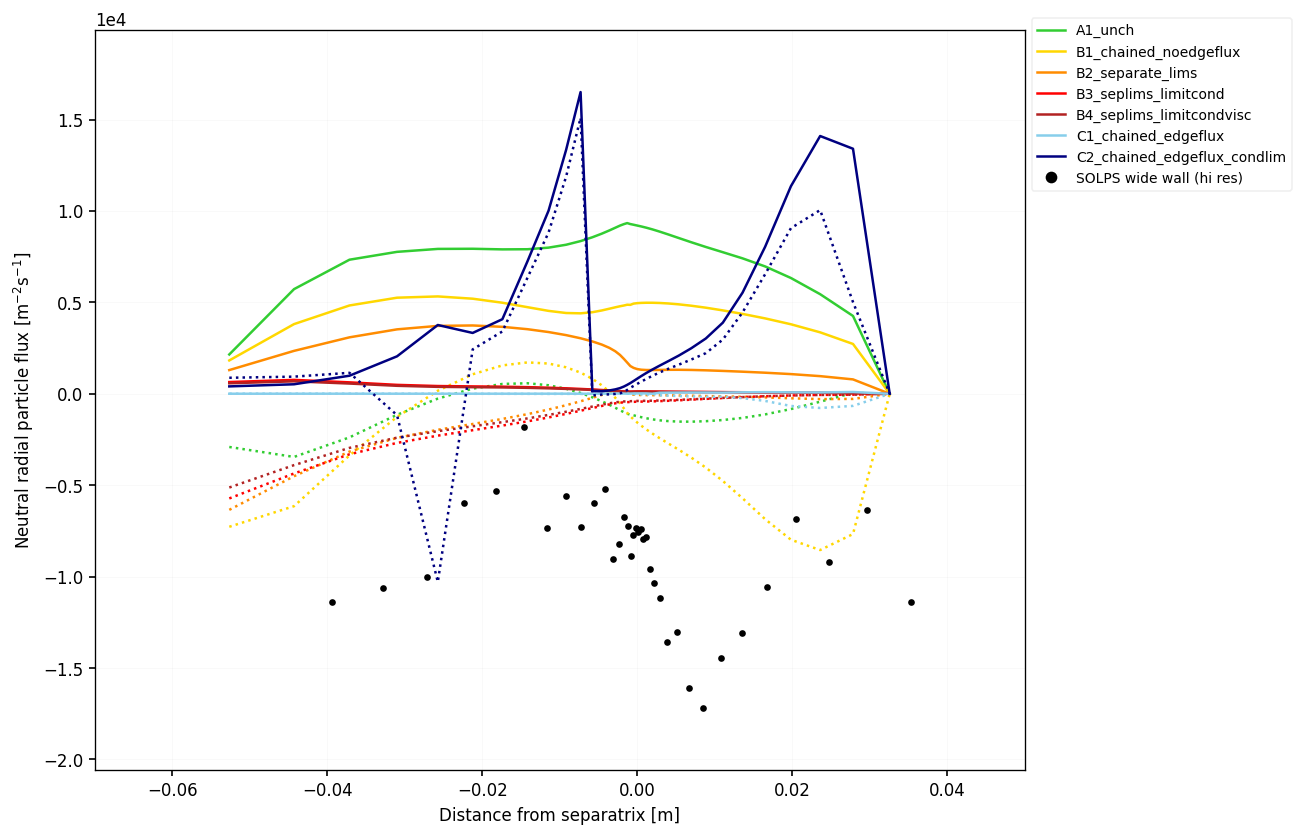

In [46]:
fig, ax = plt.subplots(figsize=(10,8), dpi = 120)
labels = ['noafn', 'afn_unchained', 'afn_chained', 'afn_chained_mfp5', 'afn_chained_mfp10']

for i, case in enumerate(casestore):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = case, color = colors[i])
    # ax.plot(dist, omp["hf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]),  color = colors[i], ls = "--")
    ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]),  color = colors[i], ls = ":")

# ax2 = ax.twinx()
# ax2.plot(dist, omp["particle_flux_factor_d"])

# SOLPS
# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (lo res)", color = "black", lw=0, marker = "o", ms = 3)
ax.plot(sp["16x_mc"].regions["omp"].index, sp["16x_mc"].regions["omp"]["pefluxa3da"] * -1, label = "SOLPS wide wall (hi res)", color = "black", lw=0, marker = "o", ms = 3)

# SOLEDGE
# slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
# df = slc.get_1d_radial_data(["vxni", "Nni"])
# df["NVxn"] = df["vxni"] * df["Nni"]
# ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE tight wall", c = "black")

# slc = SOLEDGEcase(path = soledgecases["widewall_2e19"])
# df = slc.get_1d_radial_data(["vxni", "Nni"])
# df["NVxn"] = df["vxni"] * df["Nni"]
# ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE wide wall", c = "darkorange")

ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("Distance from separatrix [m]")
fig.legend(loc = "upper left", bbox_to_anchor=(0.9,0.9), fontsize="small")
ax.set_xlim(-0.07, 0.05)
# ax.set_ylim(-1.0e20, 1.0e20)
ax.set_title("")

## A) Unchained

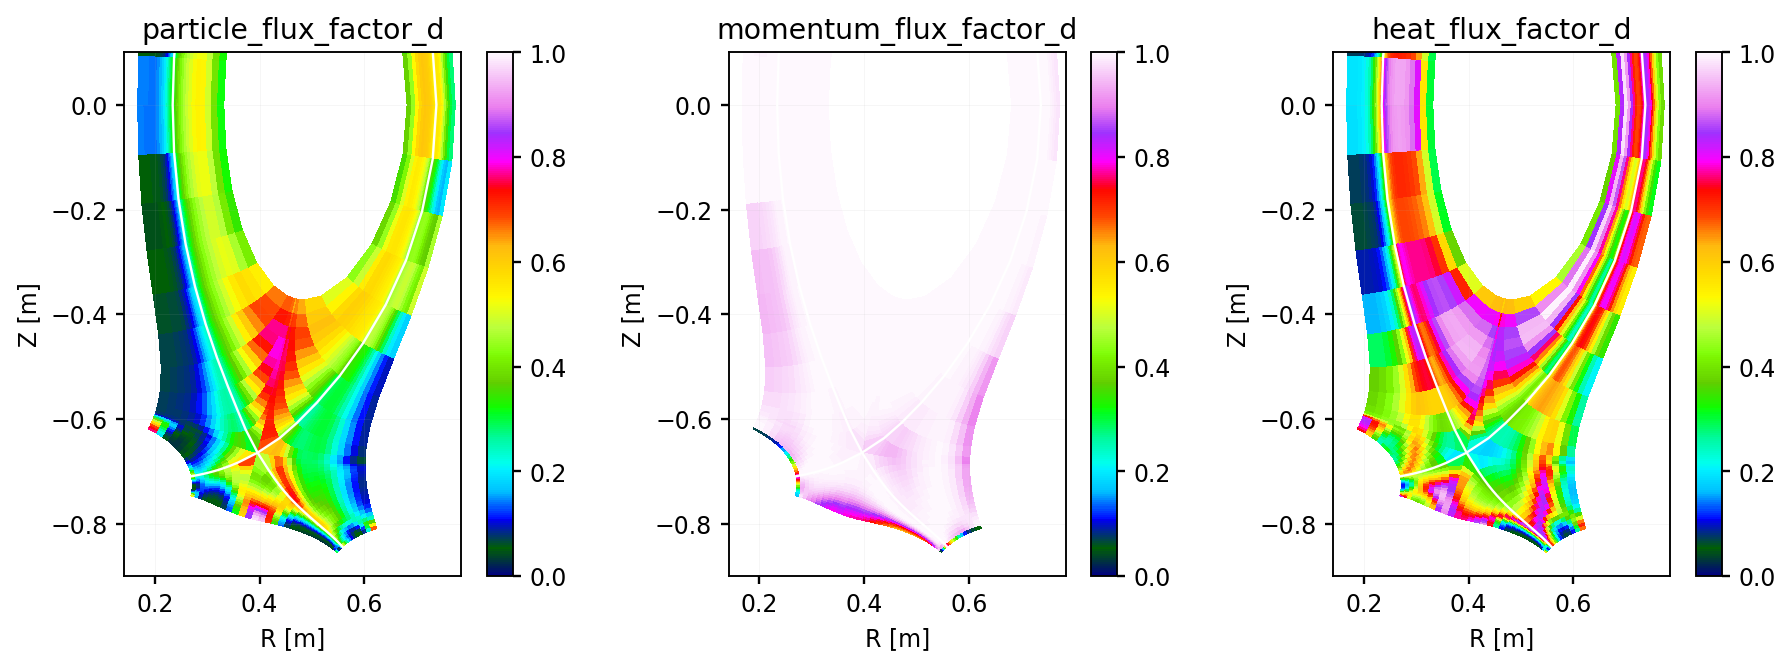

In [26]:
ds = casestore["A1_unch"].ds.isel(t=-1)

fig, axes = plt.subplots(1,3, figsize=(13,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## B) Chained, no edge fluxes

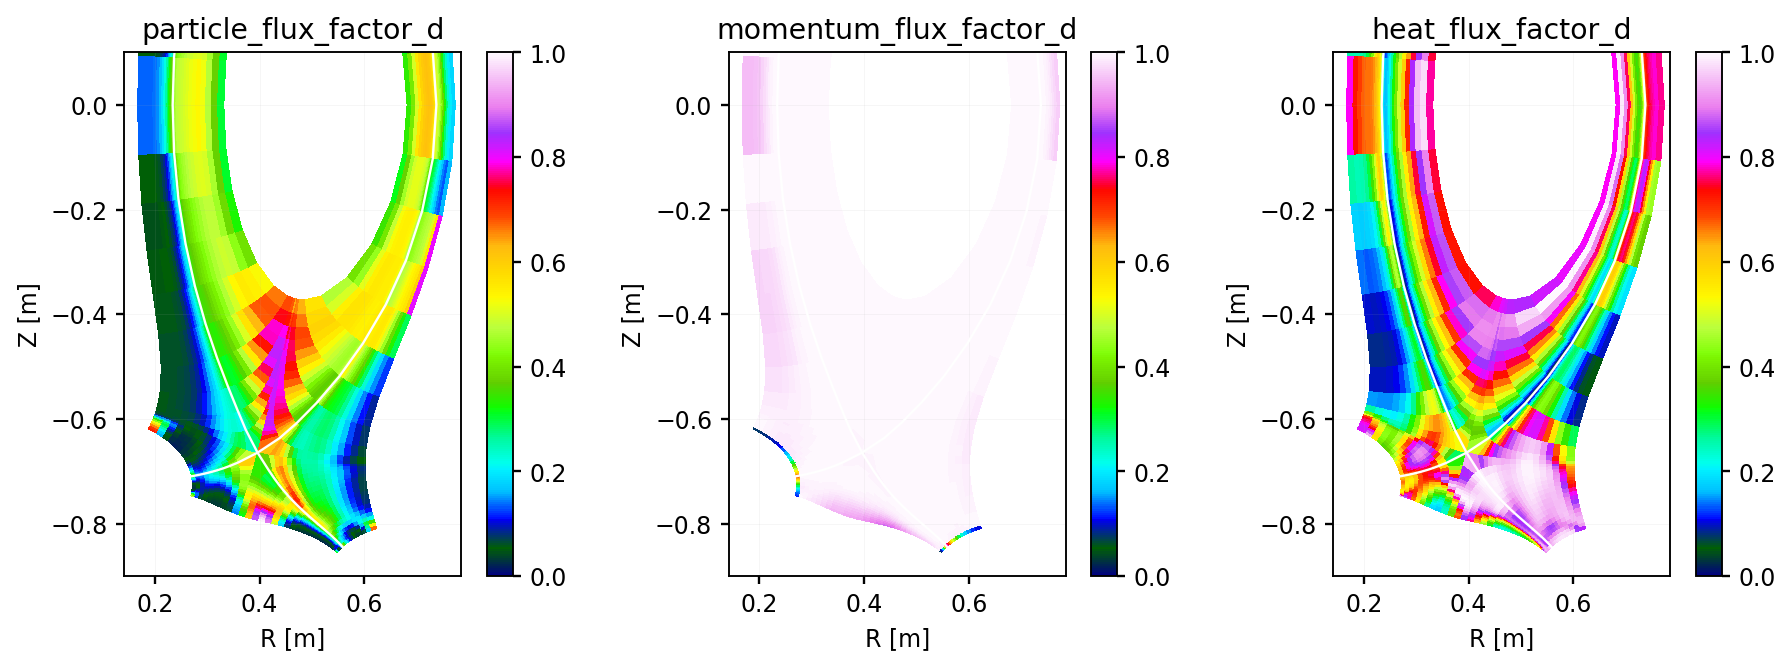

In [27]:
ds = casestore["B1_chained_noedgeflux"].ds.isel(t=-1)

fig, axes = plt.subplots(1,3, figsize=(13,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## B2) Chained, separate conduction and convection

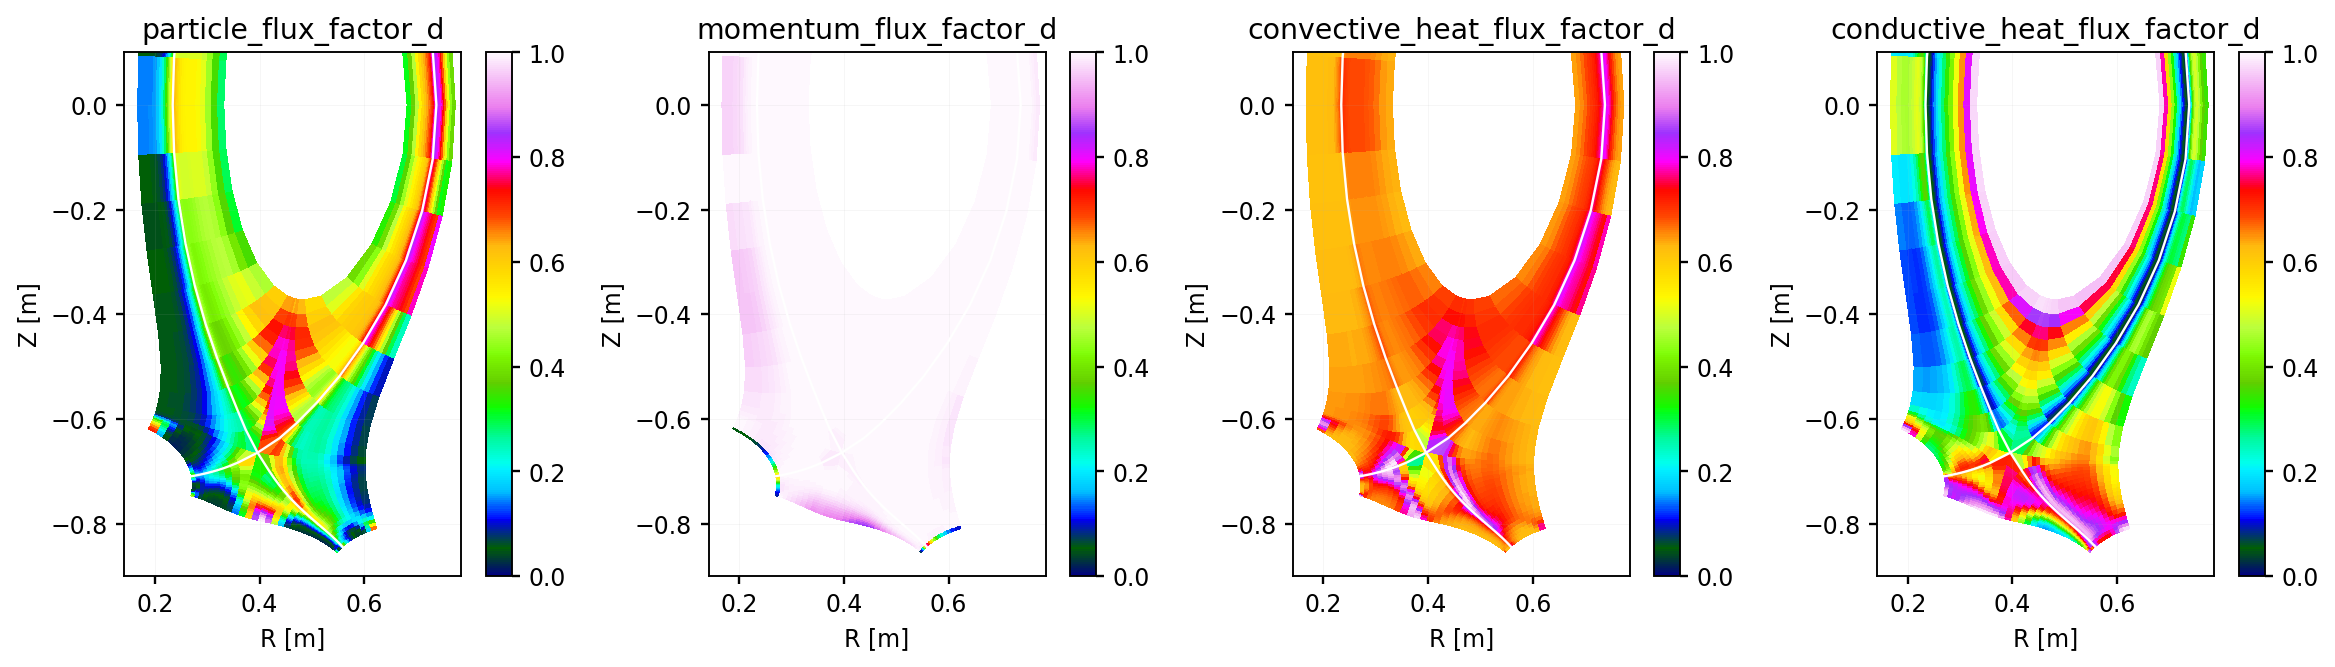

In [5]:
ds = casestore["B2_separate_lims"].ds.isel(t=-1)

fig, axes = plt.subplots(1,4, figsize=(17,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["convective_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## B3) Chained, limit conduction

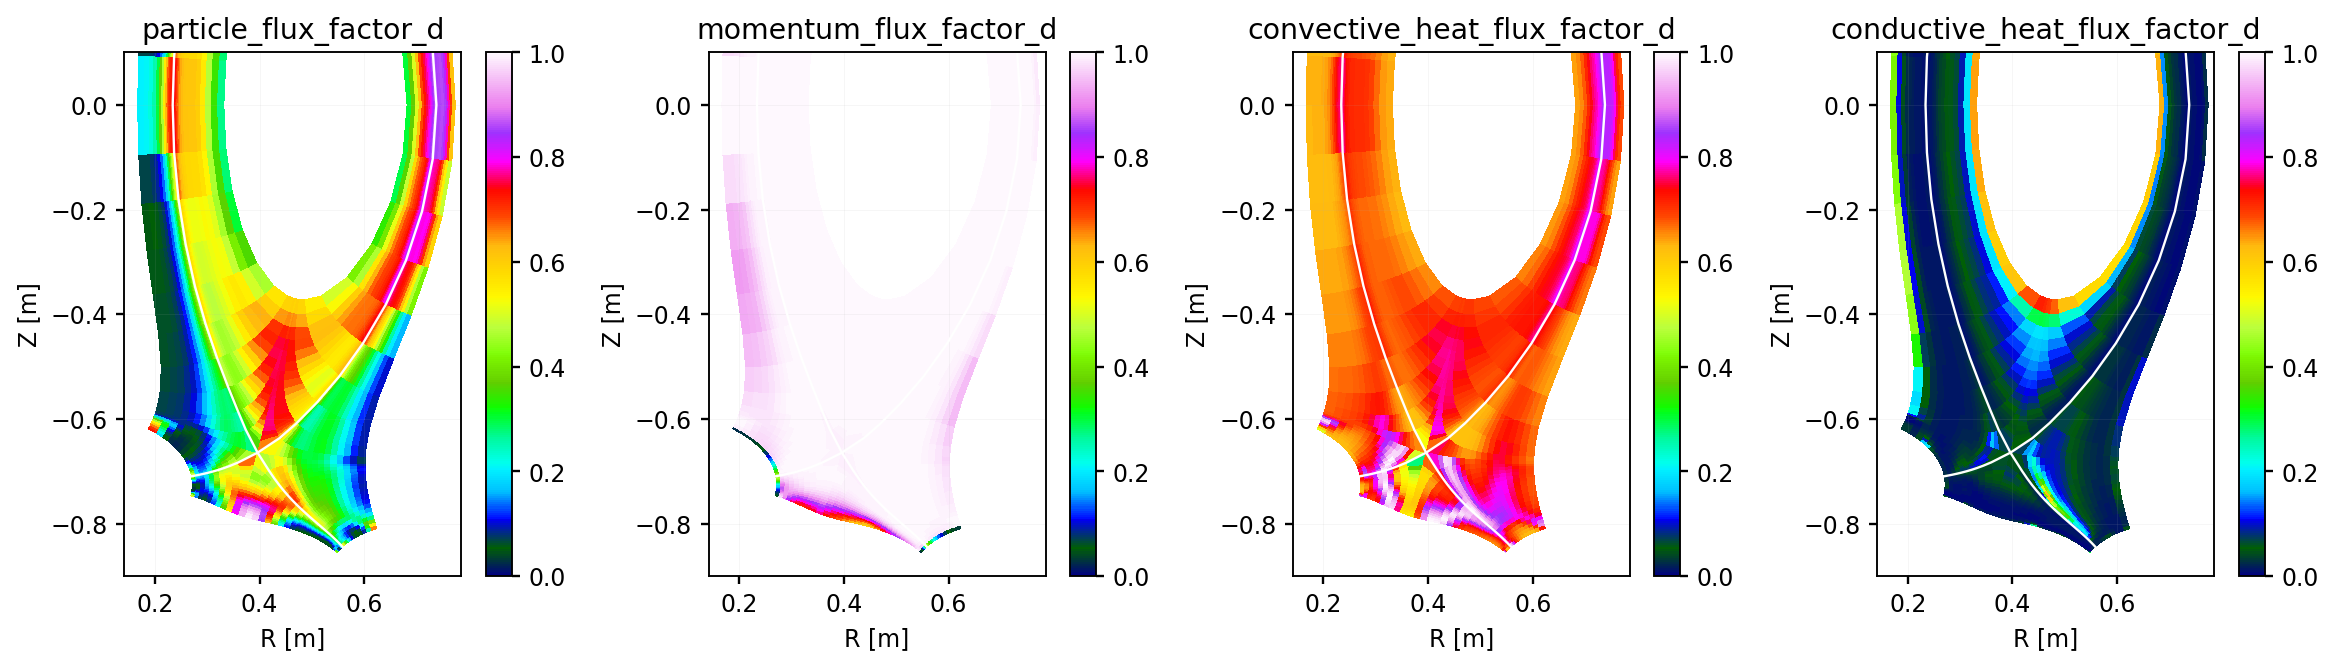

In [6]:
ds = casestore["B3_seplims_limitcond"].ds.isel(t=-1)

fig, axes = plt.subplots(1,4, figsize=(17,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["convective_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## B4) Chained, limit conduction and viscosity

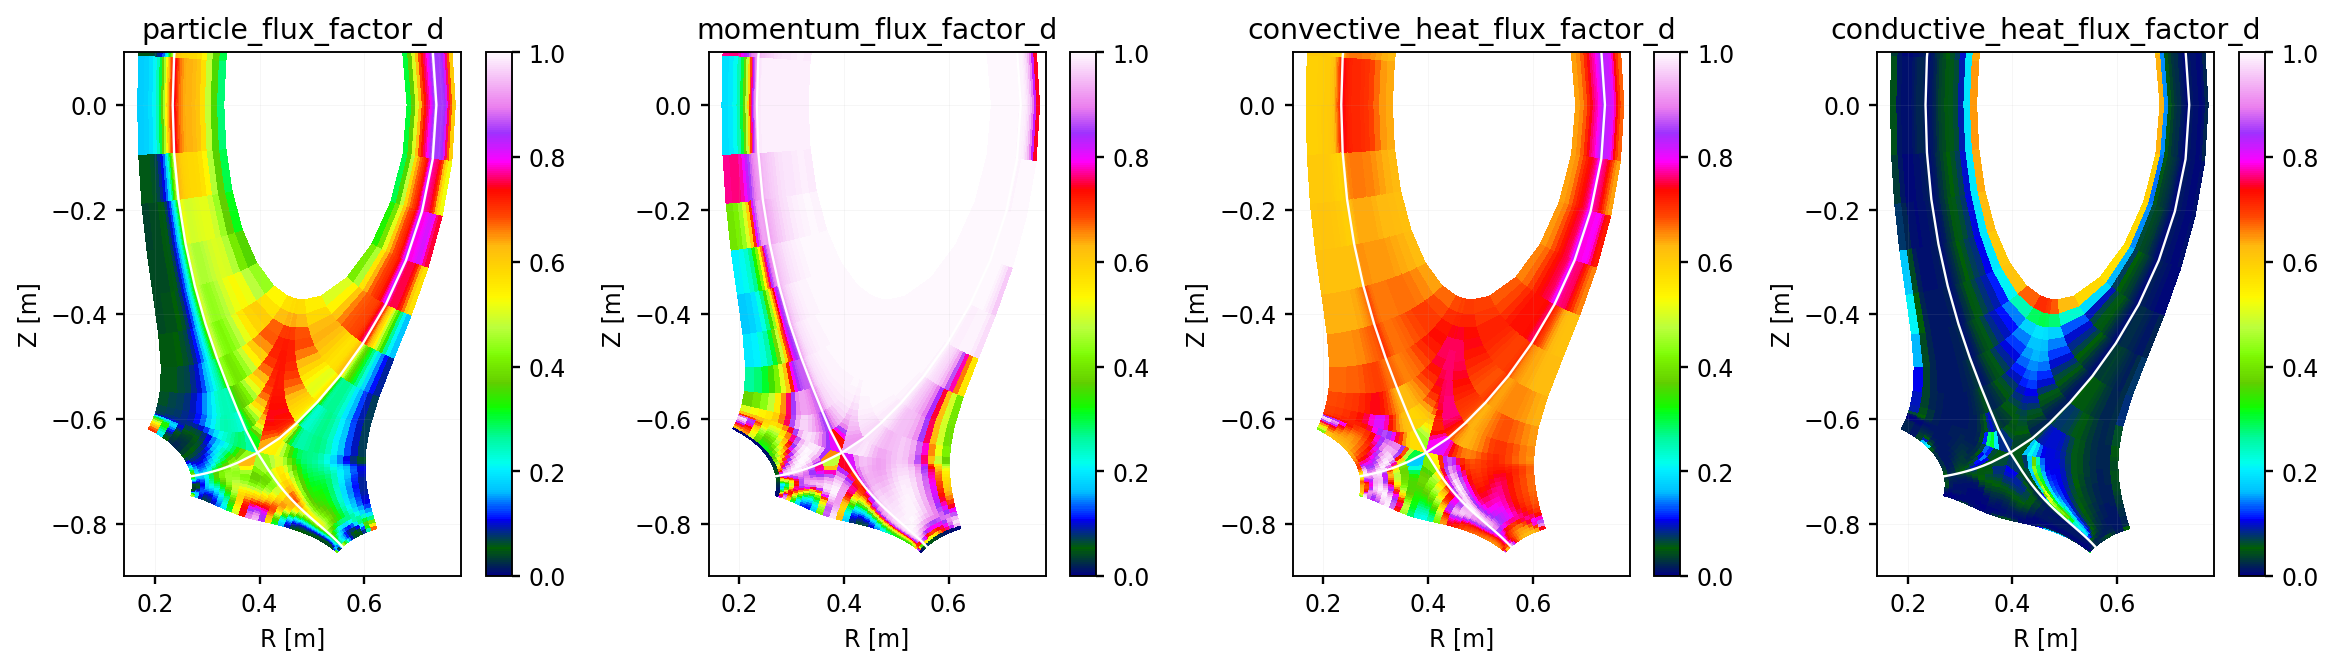

In [7]:
ds = casestore["B4_seplims_limitcondvisc"].ds.isel(t=-1)

fig, axes = plt.subplots(1,4, figsize=(17,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["convective_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["conductive_heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[3], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## C) Chained, edge fluxes

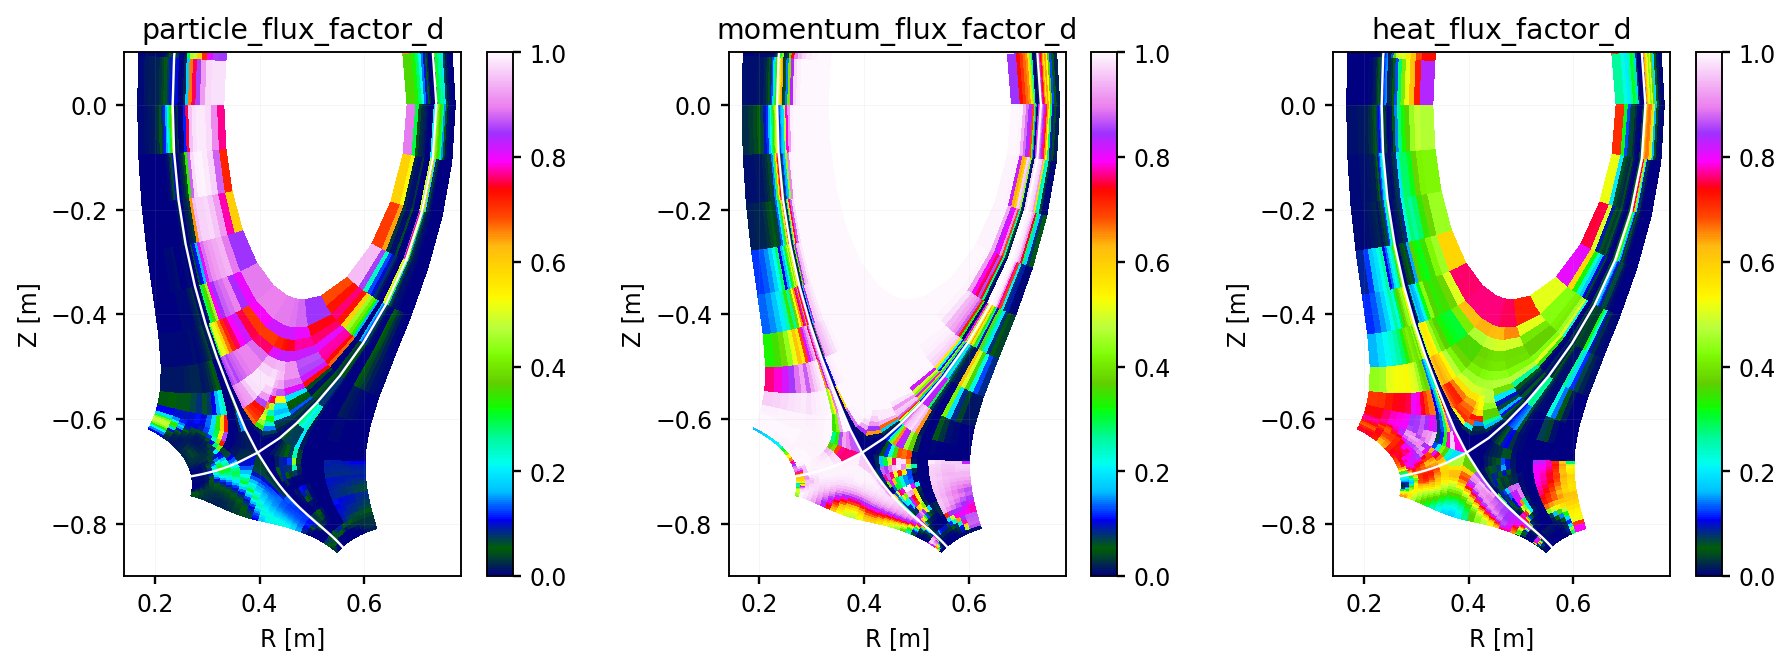

In [29]:
ds = casestore["C1_chained_edgeflux"].ds.isel(t=-1)

fig, axes = plt.subplots(1,3, figsize=(13,4), dpi = 170)
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

## C2) Chained, edge fluxes, only conduction limited

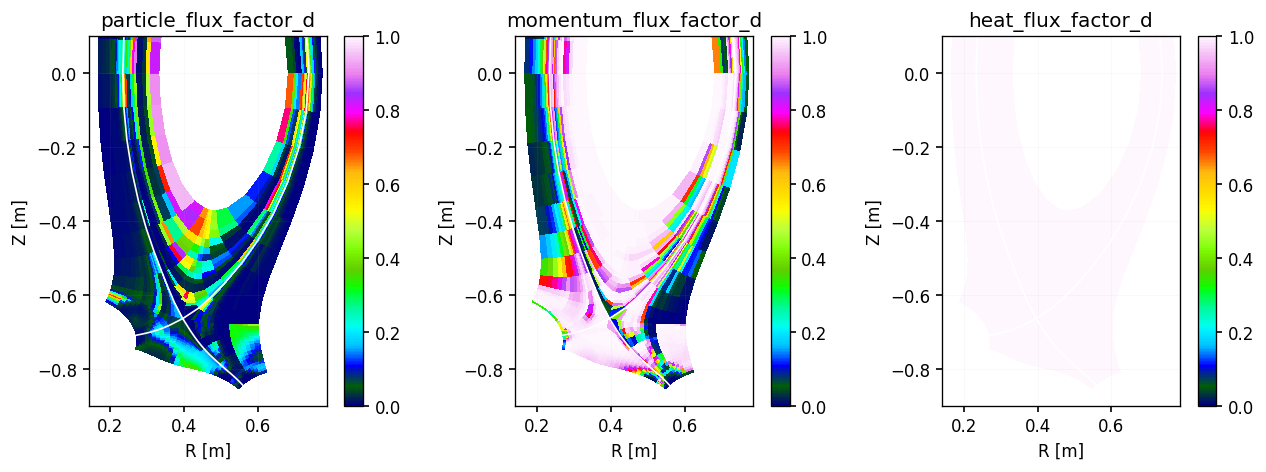

In [15]:
ds = casestore["C2"].ds.isel(t=-1)

fig, axes = plt.subplots(1,3, figsize=(13,4))
ds["particle_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["momentum_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", vmin = 0, vmax = 1)
ds["heat_flux_factor_d"].hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "gist_ncar", vmin = 0, vmax = 1)

for ax in axes:
    ax.set_ylim(-0.9,0.1)

In [14]:
casestore.keys()

dict_keys(['A1', 'B1', 'C1', 'C2'])

## Looking at the fluxes across domain

In [13]:
casestore.keys()

dict_keys(['A1_unch', 'B1_chained_noedgeflux', 'B2_separate_lims', 'B3_seplims_limitcond', 'B4_seplims_limitcondvisc', 'C1_chained_edgeflux', 'C2_chained_edgeflux_condlim'])

KeyError: 'hf_perp_conv_L_d'

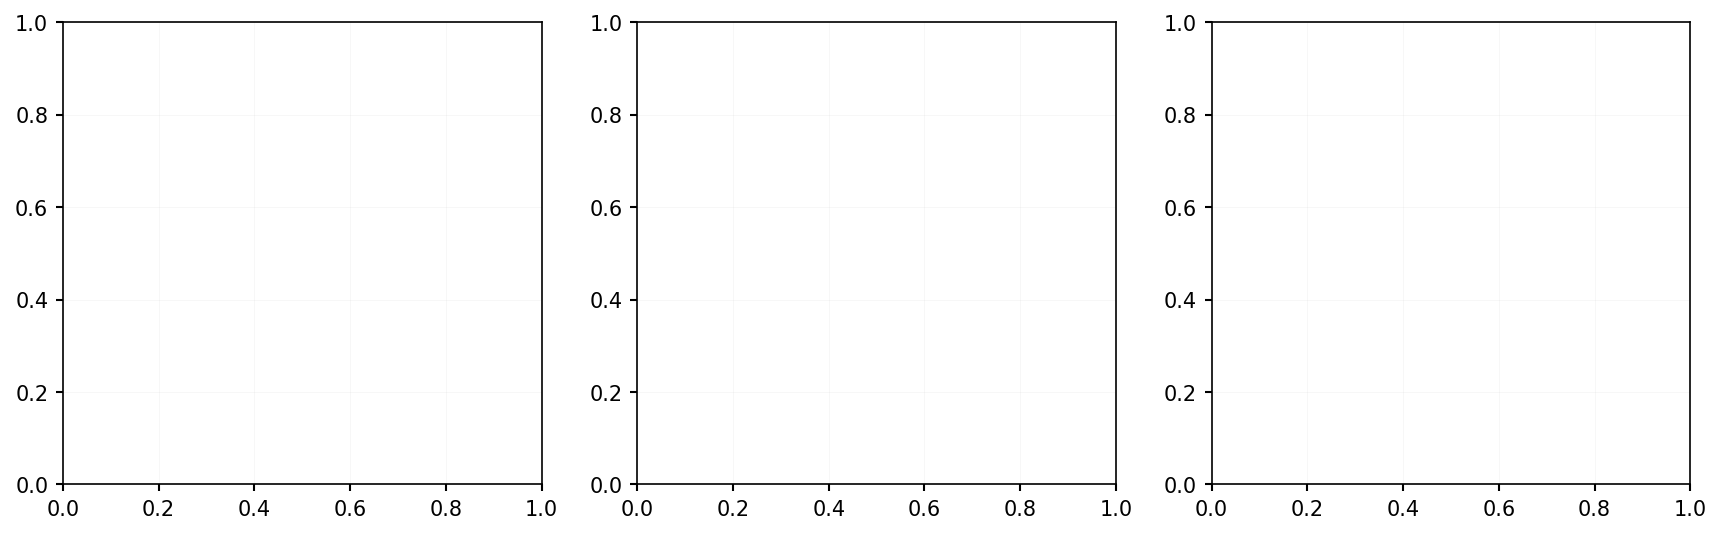

In [15]:
ds = casestore["B2_separate_lims"].ds.isel(t = -1)

fig, axes = plt.subplots(1,3, figsize = (14, 4), dpi = 150)

net_flux = ds["hf_perp_conv_L_d"] + ds["hf_perp_diff_L_d"]


ds["hf_perp_conv_L_d"].hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", logscale = True, vmin = -1e6, vmax = 1e6)
axes[0].set_title("Convection")

ds["hf_perp_diff_L_d"].hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", logscale = True, vmin = -1e6, vmax = 1e6)
axes[1].set_title("Conduction")

net_flux.hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", logscale = True, vmin = -1e6, vmax = 1e6)
axes[2].set_title("Net flux")

for ax in axes:
    ax.set_ylim(-0.85, 0.1)

In [ ]:
# Total energy flux 

In [55]:
casestore.keys()

dict_keys(['noafn', 'afn_unchained', 'afn_chained', 'afn_chained_mfp5', 'afn_chained_mfp10'])

# Total energy flux

KeyError: 'hf_perp_tot_R_d'

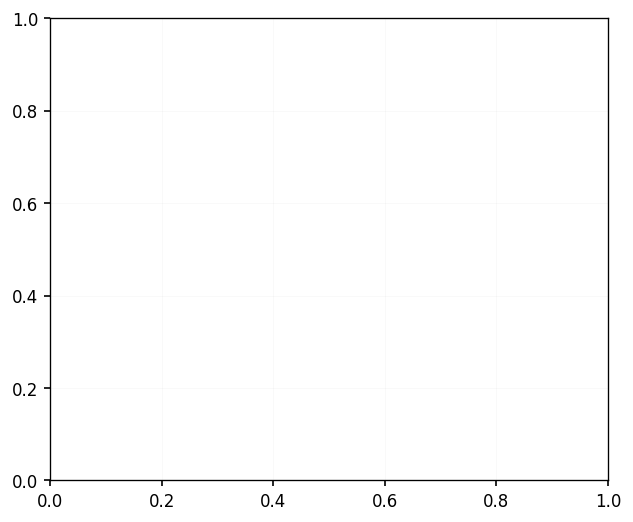

In [16]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ['noafn', 'afn_unchained', 'afn_chained', 'afn_chained_mfp5', 'afn_chained_mfp10']

for i, case in enumerate(casestore):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = case)


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS 2e19: refluxa3da", color = "black", lw=0, marker = "o", ms = 3)
ax.set_ylabel("Neutral radial energy flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")

# PARTICLE FLUX

In [51]:
sp.keys()

dict_keys(['base', 'noiz_core', 'gammai_2.5', 'dpuff_1e22', 'dpuff_5e21', 'no_fast_reflec', 'nsep_2e19', 'nsep_3e19', 'narrow_core', 'no_visc', '16x_mc'])

In [97]:
for case in casestore:
    casestore[case].ds = calculate_radial_fluxes(casestore[case].ds)
    casestore[case].ds = reverse_pfr_fluxes(casestore[case].ds)

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


Text(0.5, 1.0, '')

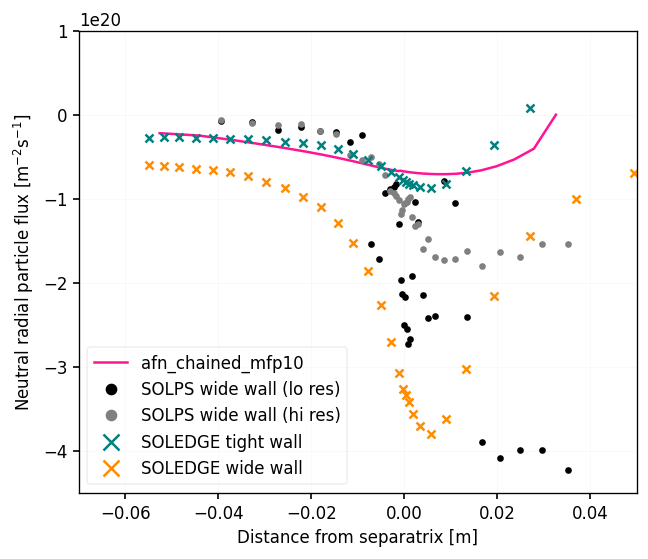

In [98]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")



fig, ax = plt.subplots()
labels = ['noafn', 'afn_unchained', 'afn_chained', 'afn_chained_mfp5', 'afn_chained_mfp10']

for i, case in enumerate(["afn_chained_mfp10"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = case, color = "deeppink")

# ax2 = ax.twinx()
# ax2.plot(dist, omp["particle_flux_factor_d"])

# SOLPS
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (lo res)", color = "black", lw=0, marker = "o", ms = 3)
ax.plot(sp["16x_mc"].regions["omp"].index, sp["16x_mc"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS wide wall (hi res)", color = "grey", lw=0, marker = "o", ms = 3)

# SOLEDGE
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE tight wall", c = "teal")

slc = SOLEDGEcase(path = soledgecases["widewall_2e19"])
df = slc.get_1d_radial_data(["vxni", "Nni"])
df["NVxn"] = df["vxni"] * df["Nni"]
ax.plot(df["dist"], df["NVxn"], lw=0, marker = "x", ms = 5, markeredgewidth=1.5, label = "SOLEDGE wide wall", c = "darkorange")

ax.set_ylabel("Neutral radial particle flux $[m^{-2}s^{-1}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()
ax.set_xlim(-0.07, 0.05)
ax.set_ylim(-4.5e20, 1e20)
ax.set_title("")

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


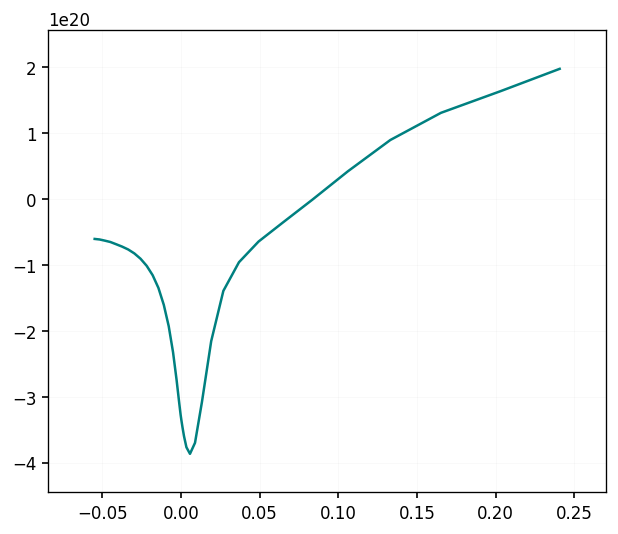

In [68]:
slc = SOLEDGEcase(path = soledgecases["tightwall_2e19_5m"])

df = slc.get_1d_radial_data(["vxni", "Nni"])

df["NVxn"] = df["vxni"] * df["Nni"]

plt.plot(df["dist"], df["NVxn"]) 


# Convective energy flux

Text(0.5, 1.0, '')

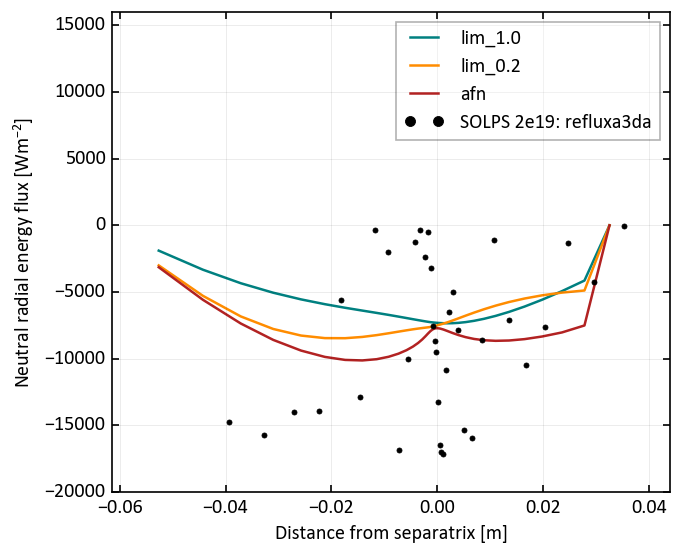

In [52]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(["lim_1.0", "lim_0.2", "isolim"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_conv_R_d"] / (omp["dy"]*omp["dz"]), label = labels[i], ls = "-")


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS 2e19: refluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial energy flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()
ax.set_ylim(-2e4, 16e3)
ax.set_title("")

Text(0.5, 1.0, 'AFN Limiter factors at OMP')

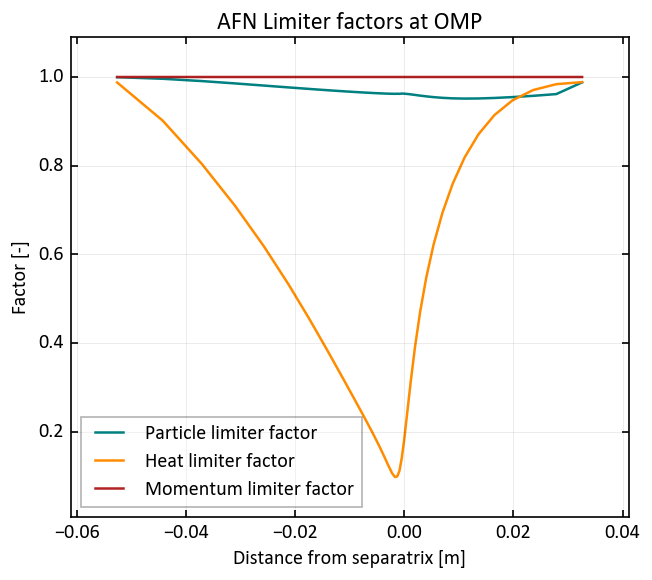

In [57]:
fig, ax = plt.subplots()

ds = casestore["isolim"].ds.isel(t=-1)
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])

ax.plot(dist, omp["particle_flux_factor_d"], label = "Particle limiter factor")
ax.plot(dist, omp["heat_flux_factor_d"], label = "Heat limiter factor")
ax.plot(dist, omp["momentum_flux_factor_d"], label = "Momentum limiter factor")

ax.legend()
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Factor [-]")
ax.set_title("AFN Limiter factors at OMP")


Text(0.5, 1.0, '')

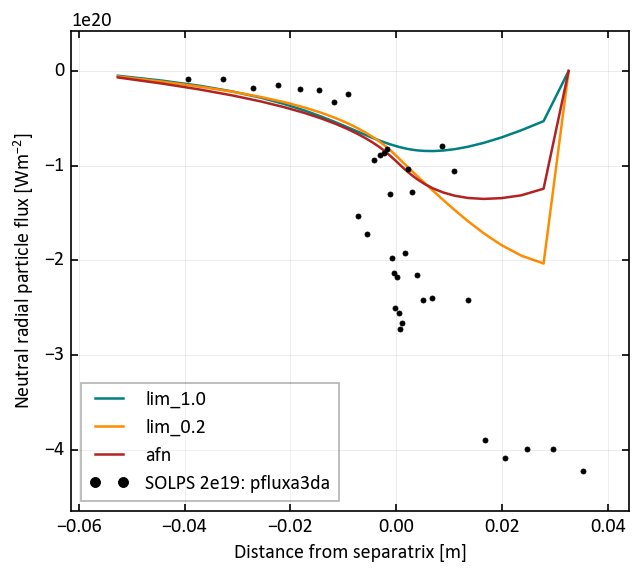

In [40]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(["lim_1.0", "lim_0.2", "isolim"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = labels[i])


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS 2e19: pfluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial particle flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")